# PyTorch Custom Dataset Notebook

## 0. Importing PyTorch and Setting Up Device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Wed Jan  8 13:10:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a writable data folder
data_path = Path('/kaggle/working/')
image_path = data_path / 'pizza-steak-sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists ...')
else:
    print(f'{image_path} does not exist, creating one ...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, and sushi data
    zip_file_path = data_path / 'pizza_steak_sushi.zip'
    with open(zip_file_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    # Unzip pizza, steak, and sushi data
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(image_path)
    
    print(f"Data downloaded and extracted to {image_path}.")

/kaggle/working/pizza-steak-sushi does not exist, creating one ...
Data downloaded and extracted to /kaggle/working/pizza-steak-sushi.


## 2. Data Preparation and Exploration

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in /kaggle/working/pizza-steak-sushi
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/train
There are 0 directories and 72 images in /kaggle/working/pizza-steak-sushi/train/sushi
There are 0 directories and 78 images in /kaggle/working/pizza-steak-sushi/train/pizza
There are 0 directories and 75 images in /kaggle/working/pizza-steak-sushi/train/steak
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/test
There are 0 directories and 31 images in /kaggle/working/pizza-steak-sushi/test/sushi
There are 0 directories and 25 images in /kaggle/working/pizza-steak-sushi/test/pizza
There are 0 directories and 19 images in /kaggle/working/pizza-steak-sushi/test/steak


In [7]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/kaggle/working/pizza-steak-sushi/train'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test'))

### 2.1 Visualising and image

Random image path: /kaggle/working/pizza-steak-sushi/train/sushi/2492146.jpg
Image class: sushi
Image height: 384
Image width: 512


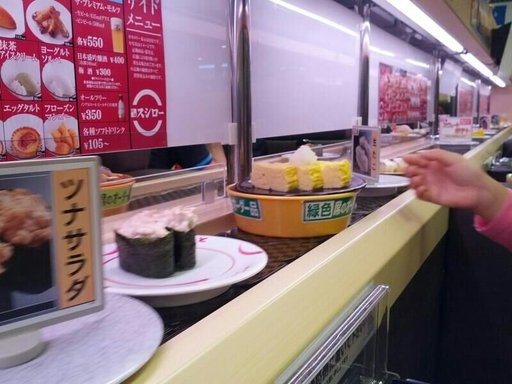

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

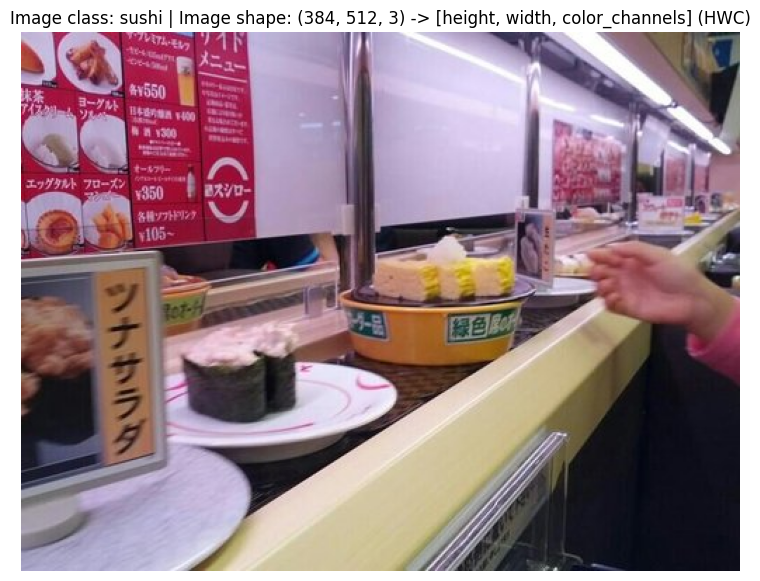

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)')
plt.axis(False);

In [10]:
img_as_array

array([[[195, 173, 212],
        [197, 176, 215],
        [201, 180, 219],
        ...,
        [ 34,  42,  45],
        [ 34,  41,  47],
        [ 36,  43,  49]],

       [[191, 174, 210],
        [192, 175, 211],
        [193, 177, 213],
        ...,
        [ 60,  68,  71],
        [ 63,  71,  74],
        [ 67,  75,  78]],

       [[192, 181, 211],
        [190, 179, 209],
        [189, 178, 210],
        ...,
        [ 86,  94,  96],
        [ 93,  98, 101],
        [ 97, 102, 105]],

       ...,

       [[167, 163, 198],
        [164, 160, 195],
        [161, 157, 192],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 14,  14,  26]],

       [[162, 158, 193],
        [161, 157, 192],
        [161, 157, 192],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 14,  14,  26]],

       [[167, 163, 198],
        [168, 164, 199],
        [171, 167, 202],
        ...,
        [ 14,  14,  26],
        [ 14,  14,  26],
        [ 15,  15,  27]]

## 3. Transforming data

Before we can use our image data with PyTorch
1. Turn the target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.tranforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.2863, 0.2196, 0.2941,  ..., 0.7451, 0.7686, 0.7608],
         [0.3020, 0.1216, 0.3020,  ..., 0.7490, 0.7804, 0.7569],
         [0.3333, 0.1059, 0.3294,  ..., 0.7529, 0.7529, 0.6824],
         ...,
         [0.0549, 0.0471, 0.0471,  ..., 0.6039, 0.5569, 0.5255],
         [0.0549, 0.0510, 0.0510,  ..., 0.6588, 0.6471, 0.6314],
         [0.0549, 0.0510, 0.0471,  ..., 0.6745, 0.6667, 0.6471]],

        [[0.3294, 0.2784, 0.3059,  ..., 0.6039, 0.7176, 0.7020],
         [0.3529, 0.1922, 0.3098,  ..., 0.6431, 0.7059, 0.5294],
         [0.3882, 0.1922, 0.3333,  ..., 0.6824, 0.5647, 0.2941],
         ...,
         [0.0549, 0.0510, 0.0510,  ..., 0.5922, 0.5412, 0.5098],
         [0.0549, 0.0510, 0.0510,  ..., 0.6431, 0.6314, 0.6157],
         [0.0549, 0.0510, 0.0471,  ..., 0.6588, 0.6510, 0.6314]],

        [[0.3373, 0.3020, 0.2902,  ..., 0.7490, 0.8510, 0.8157],
         [0.3765, 0.2941, 0.3216,  ..., 0.7882, 0.8275, 0.5961],
         [0.4157, 0.3216, 0.3412,  ..., 0.8196, 0.6510, 0.

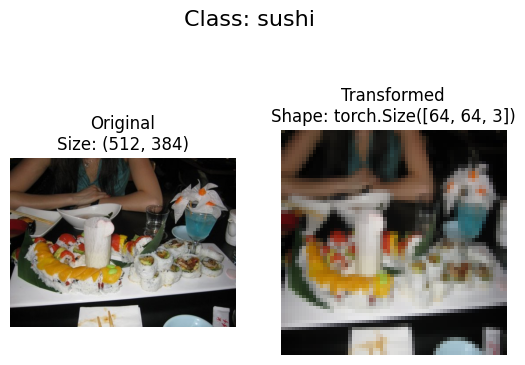

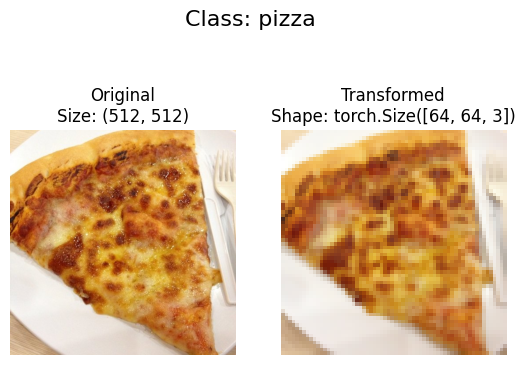

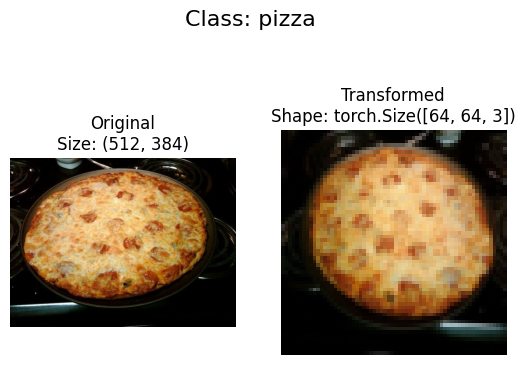

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

In [15]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /kaggle/working/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /kaggle/working/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths of our dataset
print(len(train_data), len(test_data))

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


In [17]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Label datatype: {type(label)}')

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]); Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

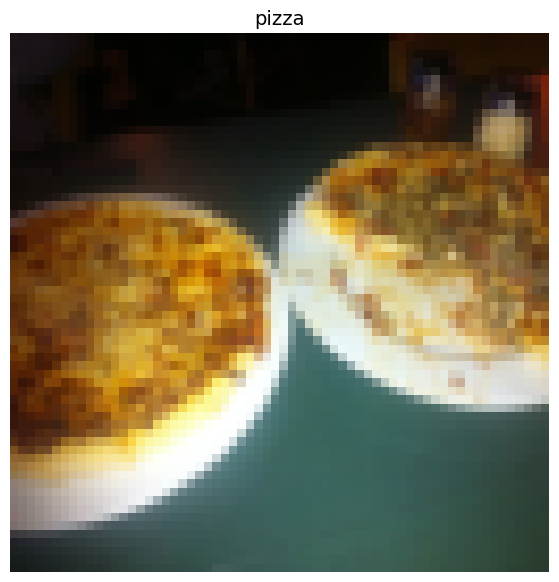

In [18]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape}; Image permute: {img_permute.shape}')

# plot the Image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

In [19]:
# 21:15